# Reconocimiento de Formas: Práctica Final (6) - OCR

En esta práctica final implementarás un OCR capaz de leer una hoja con texto escrito a máquina.

* **alumno 1**: Víctor Nieves Sánchez
* **alumno 2**: Javier Barragán Haro


Las utilidades **upm_imshow** y **upm_rectangle** te permiten respectivamente mostrar una ventana re-escalable de un tamaño determinado y dibujan un rectángulo representado como [x, y, width, height].

In [1]:
import cv2

# %matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,30)

# %pip install mpld3
import mpld3
mpld3.enable_notebook()

# ##############################################################################
# ################################## Utilities #################################
# ##############################################################################

fig_counter = [0]
    
def upm_imshow(win_name, img, win_size=800):
    """Shows a resizable window with a fixed size. No matters the image size"""
#     cv2.namedWindow(win_name, cv2.WINDOW_KEEPRATIO)
#     cv2.imshow(win_name, img)
#     h = img.shape[0]
#     w = img.shape[1]
#     max_dim = w if w > h else h
#     win_scale = win_size / max_dim
#     cv2.resizeWindow(win_name, int(w * win_scale), int(h * win_scale))

    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


def upm_rectangle(img, box, color, thickness):
    """Draws a rectangle based on a box. The box should be: [x, y, width, height]"""
    cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), color, thickness)

## Clasificadores

Implementa aquí los clasificadores que vaya a emplear para reconocer cada caracter de forma individual. 

# Reconocedor de texto
La clase **TextRecognizer** es la encargada de detectar el texto en la imagen con la ayuda de tu reconocedor de caracteres. El reconocimiento de texto tiene los siguientes pasos báásicos:

1. Detectar los caracteres como manchas negras sobre el fondo blanco (método **detect_chars**).
2. Reconocer el caracter a partir de el trocito de imagen (méétdos **predict_char** y **standardize_char_size**).
3. Agrupar los caracteres formando palabras (método **detect_words**)
4. Agrupar las palabras formando lineas de texto (método **detect_lines**)

Esta clase emplea métodos de visión por computador que están fuera del alcance de la asignatura de reconocimiento de formas. Por este motivo no es necesario que modifiques esta clase, aunque si crees que con ello puedes mejorar de alguna manera tus ratios de detección, te animamos a hacerlo!

In [2]:
import functools
import os
import random
import sys
from typing import Callable
import cv2
import numpy as np
from sklearn.base import BaseEstimator



# ##############################################################################
# ############################# Text Recognition ###############################
# ##############################################################################

class TextRecognizer:
    """
    The TextRecognizer class is a utility that allows to detect text in a scanned paper.
    The class uses computer vision classical methods to detect characters, words and lines of text.
    Characters are detected as dark blobs in the light background. A classifier specified in the
    constructor is used to recognize each character individually. Words are detected as big
    blobs and its letters are detected as the recognized chars that fall inside the word box.
    Last, line text are detected as groups of horizontally aligned word boxes.
    """

    def __init__(self, char_classifier: (Classifier, BaseEstimator), classifier_mapping: np.ndarray):
        """
        :param char_classifier: The classifier that will be used to recognize characters.
        :param classifier_mapping: The mapping from the output of the classifier (number) to chars
        """
        self.char_classifier = None
        self.classifier_mapping = classifier_mapping
        self.char_classifier = char_classifier

    def predict_char(self, X: np.ndarray):
        """
        Predicts a char based on the input bitmap X. Since the char_classifier predicts
        a index, this function converts the returned intex into a char.
        :param X: The input image with a character to recognize. Should be of type float.
        :return: The predicted char.
        """
        assert X.dtype in (float, np.float32, np.float64)
        return self.classifier_mapping[self.char_classifier.predict(X.reshape(1, -1))][0]

    @staticmethod
    def standardize_char_size(img: np.ndarray, dst_shape: tuple = (28, 28)):
        """
        Centers and scales the input image (img) to fit it in a image of shape dst_shape with a small border.
        :param img: The input image
        :param dst_shape: The destination shape. This defines also the number of features used in the classifier.
        :return: a new image where the input image has been scaled and centered.
        """
        dst = np.zeros(dst_shape, dtype=float)
        h, w = img.shape
        margin = 2
        # Scale the image to fit in the destination shape
        scale_factor = (dst_shape[0] - 2 * margin) / h if h > w else (dst_shape[1] - 2 * margin) / w
        resized = cv2.resize(img, (int(scale_factor * w), int(scale_factor * h)))
        # Convert from white background to black background
        resized = 255 - resized.astype(float)
        # Paste in the output image
        x_margin = (dst_shape[1] - resized.shape[1]) // 2
        y_margin = (dst_shape[0] - resized.shape[0]) // 2
        dst[y_margin:y_margin + resized.shape[0], x_margin:x_margin + resized.shape[1]] = resized
        return dst

    @staticmethod
    def detect_chars(bin_img: np.ndarray, predict_function: Callable):
        """
        Detects chars in the input image.
        :param bin_img: A binary image(black and white image with white background)
        where the letters are clearly visible and there is no noise!
        :param predict_function: A function to date a standardize char image and predict a letter from it.
        :return: A numpy array with the char boxes (format [x, y, width , height])
        and other numpy array with chars of each box.
        """
        # Reduce the letters thickness to make easier the segmentation
        bin_img = cv2.dilate(bin_img, np.ones((3, 3), np.uint8))

        # Find the contours of the letters. Chains of pixels around them
        _, contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        dbg_img = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR)
        dbg_img = cv2.drawContours(dbg_img, contours, -1, (0, 0, 255), 1)

        # Get the most frequently parent as the one of the letters
        poss_hierarchy = np.squeeze(hierarchy)[:, 3][np.squeeze(hierarchy)[:, 3] >= 0]
        most_freq_parent = np.argmax(np.bincount(poss_hierarchy))
        # Discard internal contours
        contours = np.array(contours)[np.squeeze(hierarchy)[:, 3] == most_freq_parent]
        # Discard small contours that use to be commas, points, accents etc.
        contours = contours[np.array(list(map(cv2.contourArea, contours))) > 120]
        # Draw the contours in the debug image
        dbg_img = cv2.drawContours(dbg_img, contours, -1, (0, 255, 0), 1)

        # Obtain the bounding boxes that surround each contour(letter)
        char_boxes = list(map(cv2.boundingRect, contours))
        if len(char_boxes) == 0:
            raise ValueError("Cannot detect any character!")

        CHAR_ASPECT_RATIO = 0.66  # Width / height
        for box in char_boxes:
            n_splits = round((box[2] / box[3]) / CHAR_ASPECT_RATIO)
            if n_splits > 2:
                # We have detected a box that clearly contains two chars
                char_boxes.remove(box)
                for i in range(n_splits):
                    char_boxes.append([int(box[0] + (box[2] / n_splits) * i), box[1], int(box[2] / n_splits), box[3]])

        detected_chars = []
        for box in char_boxes:
            # Crop the char from the full image, standardize the image size and predict its char
            cropped_image = bin_img[box[1]:box[1] + box[3], box[0]:box[0] + box[2]]
            cropped_image = TextRecognizer.standardize_char_size(cropped_image)
            # upm_imshow("Letter", cropped_image)
            # cv2.waitKey()
            pred_char = predict_function(cropped_image)
            detected_chars.append(pred_char)

            # Draw the result
            upm_rectangle(dbg_img, box, (255, 0, 255), 1)
            cv2.putText(dbg_img, pred_char, (box[0], box[1] - 4), 0, 0.7, (255, 0, 255), 2)

        # Debug imshows
        cv2.circle(dbg_img, (30, 40), 25, (0, 0, 255), -1)
        cv2.putText(dbg_img, "Discarded Contours", (70, 65), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 4)
        cv2.circle(dbg_img, (30, 100), 25, (0, 255, 0), -1)
        cv2.putText(dbg_img, "Contours considered Letters", (70, 125), cv2.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 4)
        upm_imshow("Detected Chars", dbg_img)

        # Join all the characters in a str
        return np.array(char_boxes), np.array(detected_chars)

    @staticmethod
    def detect_words(bin_img: np.ndarray, char_boxes: np.ndarray, detected_chars: np.ndarray):
        """
        Detects words in the input image given a set of pre-recognized chars.
        :param bin_img: A binary image(black and white image with white background)
        where the words are clearly visible and there is no noise!
        :param char_boxes: A numpy array containing at each row the information of a
        char box in format [x, y, width, height].
        :param detected_chars: A numpy array with the char of each box.
        :return:  A numpy array with the boxes around each word
        and other numpy array with the text of each word.
        """
        assert len(char_boxes > 0) and len(detected_chars) == len(char_boxes)

        # Take a color copy of the input image for debug purposes
        dbg_img = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR)

        erode_kernel = np.ones((3, 17), np.uint8)
        bin_img = cv2.erode(bin_img, erode_kernel)
        # upm_imshow("Words dilated Image", bin_img)

        # Find the contours of the letters. Chains of pixels around them
        _, contours, hierarchy = cv2.findContours(bin_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        # Discard internal contours
        # Get the most frequently parent as the one of the words
        poss_hierarchy = np.squeeze(hierarchy)[:, 3][np.squeeze(hierarchy)[:, 3] >= 0]
        most_freq_parent = np.argmax(np.bincount(poss_hierarchy))
        contours = np.array(contours)[np.squeeze(hierarchy)[:, 3] == most_freq_parent]
        word_boxes = list(map(cv2.boundingRect, contours))

        if len(word_boxes) == 0:
            raise ValueError("Cannot detect any word!")

        detected_words = []
        # Convert the char boxes to a numpy array
        char_boxes = np.squeeze(np.array([char_boxes]))
        for box in word_boxes:
            inside = np.logical_and(np.logical_and(char_boxes[:, 0] >= box[0],
                                                   char_boxes[:, 1] >= box[1]),
                                    np.logical_and(char_boxes[:, 0] + char_boxes[:, 2] <= box[0] + box[2],
                                                   char_boxes[:, 1] + char_boxes[:, 3] <= box[1] + box[3]))

            # Take the order of the boxes by its x-coordinate
            chars_order = np.argsort(char_boxes[inside, 0])
            # Sort the chars by the ordered indices
            word = ''.join(detected_chars[inside][chars_order])
            detected_words.append(word)

            # Draw the result
            upm_rectangle(dbg_img, box, (255, 0, 0), 2)
            cv2.putText(dbg_img, word, (box[0], box[1] - 4), 0, 1.2, (255, 0, 0), 3)

        upm_imshow("Detected Words", dbg_img)
        return np.array(word_boxes), np.array(detected_words)

    @staticmethod
    def detect_lines(bin_img: np.ndarray, word_boxes: np.ndarray, detected_words: np.ndarray):
        """
        Detects lines in the input image given a set of pre-recognized words.
        :param bin_img: A binary image(black and white image with white background).
        :param word_boxes: A numpy array with the boxes around each word. Format [x, y, width, height]
        :param detected_words: Numpy array with the text of each word.
        :return: A list with each text line detected in the document. A text line is
         represented by a dictionary with the following entries:
         - line_box: A box around the words in the text line. Format: [x, y, width, height]
         - word_boxes: A numpy array with the word boxes inside the text line.
         - words: A numpy array with the words in the line.
        """
        assert len(word_boxes > 0) and len(detected_words) == len(word_boxes)

        # Sort the words by its X coordinate
        left_order_idx = np.argsort(word_boxes[:, 0])
        boxes_to_take = word_boxes[left_order_idx].copy()
        words_to_take = detected_words[left_order_idx].copy()

        dbg_img = cv2.cvtColor(bin_img, cv2.COLOR_GRAY2BGR)
        lines = []
        # For each line in the document
        while len(boxes_to_take) > 0:
            initial_center = boxes_to_take[0, :2] + boxes_to_take[0, 2:] / 2

            # Select the boxes at the same height that the initial_box
            aligned = np.logical_and(boxes_to_take[:, 1] <= initial_center[1],
                                     boxes_to_take[:, 1] + boxes_to_take[:, 3] >= initial_center[1])
            aligned = np.argwhere(aligned).flatten()

            # Sort selected words from left to right
            selected_indices = np.argsort(boxes_to_take[aligned, 0].flatten())
            selected_boxes = boxes_to_take[aligned][selected_indices]
            selected_words = words_to_take[aligned][selected_indices]
            # Create line bix in format: [x, y, width, height]
            line_box = [selected_boxes[:, 0].min(),
                        selected_boxes[:, 1].min(),
                        np.max(selected_boxes[:, 0] + selected_boxes[:, 2]) - selected_boxes[:, 0].min(),
                        np.max(selected_boxes[:, 1] + selected_boxes[:, 3]) - selected_boxes[:, 1].min()]

            if line_box[2] * line_box[3] > 1500:
                # Append the line to the list if it is big
                lines.append({'line_box': line_box, 'word_boxes': selected_boxes, 'words': selected_words})

                # Draw the result
                upm_rectangle(dbg_img, line_box, (255, 0, 255), 3)
                line_text = functools.reduce(lambda a, b: a + ' ' + b, selected_words)
                cv2.putText(dbg_img, line_text, (line_box[0], line_box[1] - 6), 0, 1.2, (255, 0, 255), 3)

            # Delete selected element
            mask = np.ones(len(boxes_to_take), np.bool)
            mask[aligned] = 0
            boxes_to_take = boxes_to_take[mask]
            words_to_take = words_to_take[mask]

        upm_imshow("Detected Lines", dbg_img)
        # Sort the lines by its Y coordinates
        lines.sort(key=lambda l: l['line_box'][1])
        return lines

    def detect_image_text(self, image_path: str):
        """
        Detects text in an image of a scanned sheet paper. Text should be written in
        :param image_path: The path where the image is stored on disk.
        :return: The detected text lines and the full text.
        """
        # Read the input image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError("Cannot find file \"{}\"".format(image_path))
        assert img.shape[0] > img.shape[1], "Error: The image should be a portrait paper."

        # Resize image to a fixed processing size
        IMG_WIDTH = 2500.0  # pixels
        scale_factor = IMG_WIDTH / img.shape[1]
        img = cv2.resize(img, (int(scale_factor * img.shape[1]), int(scale_factor * img.shape[0])))

        # Blur image to remove some noise
        blur = cv2.GaussianBlur(img, (5, 3), 1)
        # upm_imshow("Blurred Image", blur)

        # Binarize image using the smart Otsu binarization method
        bin_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        # upm_imshow("Binary Image", bin_img)

        # Detect individual chars
        char_boxes, detected_chars = self.detect_chars(bin_img, self.predict_char)
        # Detect words based on the detected chars
        word_boxes, detected_words = self.detect_words(bin_img, char_boxes, detected_chars)
        # Detect text lines based on the detected words
        lines = self.detect_lines(bin_img, word_boxes, detected_words)

        # convert from the lines dictionary format to a string with all the text
        text = ''
        line_words = []
        for l in lines:
            line_words.append(l['words'])
            text += functools.reduce(lambda a, b: a + ' ' + b, l['words']) + '\n'

        return line_words, text


NameError: name 'Classifier' is not defined

## Entrenamiento del reconocedor de caracteres

Dado que no siempre existe una base de datos que cumpla todos nuestros requisitos, en esta prááctica os proporcionamos el cóódigo para que generééis vuestra propia base de datos de caracteres. La aproximación que os proponemos es la más inocente de todas: una base de datos sintéética.

En este código se genera una base de datos donde cada ejemplo es la imagen de un caracter. Las imágenes se generan empleando la librería de python **PIL** en el méétdo **generate_ttf_images**. Para dotar de un poco de realismo a la base de datos se añaden distintos tipos de ruido con la función **add_noise_to_img**. Por úúltimo las imágenes se binarizan y se escalan a una imagen de 28 x 28, empleando el mismo método que se emplea en la clase TextRecognizer.

In [5]:
# ##############################################################################
# ########################### Dataset Generation ###############################
# ##############################################################################

def add_noise_to_img(img, rot_noise_level=3, scale_noise_level=0.06, gauss_noise_level=20, blur_noise_level=6,
                     salt_level=1, dilate_level=11):

    img = cv2.dilate(img, np.ones((dilate_level, dilate_level), np.uint8))

    # salt and pepper
    for _ in range(int(img.shape[0] * salt_level)):
        img[np.random.randint(0, img.shape[0]), np.random.randint(0, img.shape[1])] = random.randint(0, 255)

    blur_level = random.randint(0, blur_noise_level) * 2 + 1
    img = cv2.GaussianBlur(img, (blur_level, blur_level), 1)
    rot_noise = 2 * rot_noise_level * np.random.normal() - rot_noise_level
    scale_noise = 1 + 2 * scale_noise_level * np.random.normal() - scale_noise_level
    A = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), rot_noise, scale_noise)
    noisy = cv2.warpAffine(img, A, (img.shape[1], img.shape[0]))

    pixel_noise = np.random.normal(size=noisy.shape) * gauss_noise_level
    noisy = np.clip(noisy.astype(float) + pixel_noise, 0, 255).astype(np.uint8)
    # upm_imshow("After", noisy)
    # cv2.waitKey()

    return noisy


def generate_ttf_images(ttf_filename, n_samples, chars_to_gen):
    from PIL import ImageDraw, Image, ImageFont

    font = ImageFont.truetype(ttf_filename, 220)

    X = []
    labels = []
    for i in range(len(chars_to_gen)):
        for _ in range(n_samples):
            c = chars_to_gen[i]
            gen_shape = (200, 200)
            image = Image.new('RGB', gen_shape)
            draw = ImageDraw.Draw(image)

            draw.text((25, 20), c, font=font)
            img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

            # Add noise
            img = add_noise_to_img(img)

            img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            _, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            contours = np.array(contours)
            contours = contours[np.array(list(map(cv2.contourArea, contours))) > 20]
            char_box = cv2.boundingRect(contours[0])
            char_crop = img[char_box[1]:char_box[1] + char_box[3], char_box[0]:char_box[0] + char_box[2]]
            img = TextRecognizer.standardize_char_size(255 - char_crop)
            X.append(img)
            labels.append(i)
            # upm_imshow("Img", img)
            # cv2.waitKey()

    return np.array(X), np.array(labels)


In [13]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
# Loading Isolet indices from Drive
#from google.colab import drive
from sklearn.datasets import load_iris

import os
current_path = os.getcwd()

#drive.mount('/content/gdrive')
#resources_dir = '/content/gdrive/My Drive/Colab Notebooks/RF19/Practica6/resources'
resources_dir = current_path + '/resources'
print(resources_dir)


print("################################################################################")
print("########################## Text Recognition Example ############################")
print("################################################################################")

print("--> Generating training dataset")
labels = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
                   'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
                   ])
font_filename = os.path.join(resources_dir, "AndaleMono.ttf")
X_train, y_train = generate_ttf_images(font_filename, 50, labels)
X_train = X_train.reshape(len(X_train), -1).astype(float)

print("--> Generating test dataset")
X_test, y_test = generate_ttf_images(font_filename, 10, labels)
X_test = X_test.reshape(len(X_test), -1).astype(float)

/home/victor/Descargas/asignaturas/reconocimiento de formas/reconocimiento-de-formas/practicas/Reconocimiento de texto/resources
################################################################################
########################## Text Recognition Example ############################
################################################################################
--> Generating training dataset


ValueError: not enough values to unpack (expected 3, got 2)

NameError: name 'X_train' is not defined

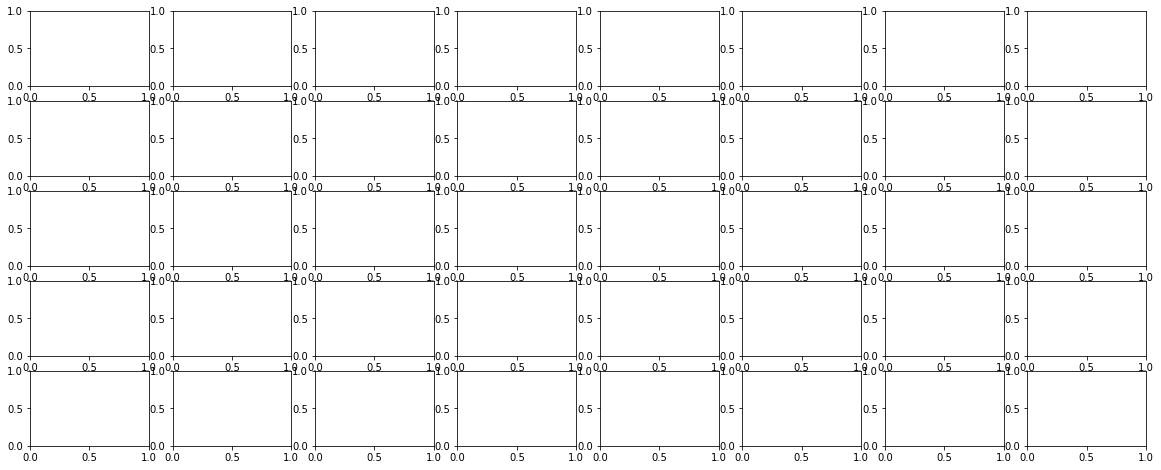

In [8]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(5, 8, figsize=(20, 8))
for i in range(len(axs)):
    for j in range(len(axs[i])):
      axs[i, j].imshow(X_train[50 * i + j].reshape((28, 28)), cmap='gray', interpolation='nearest')


## Entrenar nuestro clasificador de caracteres
Es hora de entrenar y evaluar el clasificador de caracteres que luego seráá empleado por la clase TextRecognizer.

In [ ]:
from sklearn.neighbors import NearestCentroid

# Learn to predict the indices
print("--> Training classifier")
clf = NearestCentroid()  # TODO Usa aquí el clasificador que desees

clf.fit(X_train, y_train)

print("--> Evaluating classifier")
pred = clf.predict(X_train)
accuracy = (y_train == pred).sum() / len(pred)
print("----> Training accuracy: {:.2f}%".format(100 * accuracy))

pred = clf.predict(X_test)
accuracy = (y_test == pred).sum() / len(pred)
print("----> Test Accuracy: {:.2f}%".format(100 * accuracy))

## Detección y reconocimiento de texto con el clasificador de caracteres

La clase TextRecognezer espera como parámetros un clasificador de caracteres y un mapping que transforme las salidas de enteros a letras.

Para hacer el reconocimiento completo de texto podríamos emplear el método **detect_image_text**, pero vamos a ejecutar paso a paso cada una de sus instrucciones para vber cómo funciona este detector de caracteres:

In [ ]:
# Read the input image
tr = TextRecognizer(clf, labels)
image_path = os.path.join(resources_dir, 'EJEMPLO_PRACTICA6.JPG')

# Read the input image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("Cannot find file \"{}\"".format(image_path))
assert img.shape[0] > img.shape[1], "Error: The image should be a portrait paper."

# Resize image to a fixed processing size
IMG_WIDTH = 2500.0  # pixels
scale_factor = IMG_WIDTH / img.shape[1]
img = cv2.resize(img, (int(scale_factor * img.shape[1]), int(scale_factor * img.shape[0])))

# Blur image to remove some noise
blur = cv2.GaussianBlur(img, (5, 3), 1)
plt.imshow(blur, cmap='gray')

## Binarización de la imagen de entrada
Hasta el momento lo que hemos hecho ha sido:

* Leer la imagen de entrada
* Convertirla a escala de grises
* Redimensionarla para que los caracteres tenga un tamaño considerable
* Difuminarla un poco para eliminar ruido que pueda afectar a la detección.

Para poder proceder a la detección de los caracteres tenemos que saber de forma inequívoca donde hay un caracter y donde no. Con este objetivo convertimos la image a una imagen binaria, donde los píxeles solo pueden tomar dos valores 0 y 255. Consideraremos que todos los píxeles con valor 255 son candidatos a estar en una letra.

In [9]:
# Binarize image using the smart Otsu binarization method
bin_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
plt.imshow(bin_img, cmap='gray')

NameError: name 'blur' is not defined

In [10]:
# Detect individual chars
char_boxes, detected_chars = tr.detect_chars(bin_img, tr.predict_char)

NameError: name 'tr' is not defined

In [11]:
# Detect words based on the detected chars
word_boxes, detected_words = tr.detect_words(bin_img, char_boxes, detected_chars)

NameError: name 'tr' is not defined

In [12]:
# Detect text lines based on the detected words
lines = tr.detect_lines(bin_img, word_boxes, detected_words)

# convert from the lines dictionary format to a string with all the text
detected_text = ''
line_words = []
for l in lines:
    line_words.append(l['words'])
    detected_text += functools.reduce(lambda a, b: a + ' ' + b, l['words']) + '\n'

NameError: name 'tr' is not defined

## Evaluación empírica del resultado
Para evaluar el resultado obtenido en el reconocimiento del texto te proporcionamos una funcióón que te indica el ratio de texto correctamente detectado. Esta funcióón te serviráá para poder comparar los resultados de distintos clasificadores, bases de datos o características que creas que pueden mejorar el rendimiento. 

In [ ]:
# ##############################################################################
# ################################# Evaluation #################################
# ##############################################################################

def evaluate_text_detection(line_words):
    """
    Evaluates the detection of the text in images.
    :param line_words: A list of lists with the line words.
    :return: A ratio of detected characters. 0 is the worse results, 1 means perfect detection.
    """
    expected_lines = [
        "RECONOCIMIENTO DE FORMAS 2019/20",
        "TRATAMIENTO DE UN PROBLEMA REAL DE RECONOCIMIENTO DE TEXTO",
        "EL OBJETIVO DE ESTA ULTIMA PARTE DE LA PRACTICA ES ENFRENTARSE A UN PROBLEMA",
        "REAL DE RECONOCIMIENTO DE FORMAS COMO ES LA LECTURA AUTOMATICA DE TEXTO",
        "ESCANEADO EN ESTA PRACTICA SE PROPORCIONA UN METODO DE EVALUACION QUE PERMITE",
        "CONOCER EL RATIO DE TEXTO CORRECTAMENTE DETECTADO SE DEBE TRATAR DE OBTENER LOS",
        "MEJORES RESULTADOS",
        "1 INTRODUCCION",
        "EN ESTA PRACTICA SE DESARROLLARA UN CODIGO CAPAZ DE RECONOCER EL TEXTO DE ESTA",
        "PRIMERA HOJA DEL ENUNCIADO COMO EN MUCHAS SITUACIONES DE LA VIDA REAL EL",
        "ALUMNO DESCONOCERA LAS IMAGENES QUE SE EMPLEARAN PARA LA EVALUACION POR LO QUE",
        "SE LE RECOMIENDA IMPRIMIR ESTA PRIMERA HOJA DEL ENUNCIADO Y LA FOTOGRAFIARLA",
        "REPETIDAS VECES DE TAL MODO QUE PUEDA OBTENER SU PROPIO CONJUNTO DE VALIDACION",
        "LO MAS COMPLETO POSIBLE",
        "SE CREARA UNA COMPETICION EN EL AULA VITUAL DONDE EL ALUMNO DEBE PUBLICAR EL",
        "RESULTADO DE PROCESAR LA IMAGEN EJEMPLO_PRACTICA6JPG QUE SE LE PROPORCIONA",
        "LA POSICION EN ESTE CONCURSO SERA UNO DE LOS CRITERIOS DE CALIFICACION DE LA",
        "PRACTICA",
        "2 ALCANCE",
        "EN EL FICHERO ESQUELETO6IPYNB QUE SE PUEDE ENCONTRAR EN EL AULA VIRTUAL SE",
        "PROPORCIONA CODIGO PARA AYUDAR EN LAS DISTINTAS FASES DEL PROCESO DE",
        "RECONOCIMIENTO ESTE CODIGO LEE UNA IMAGEN DE DISCO Y APLICA DIVERSOS",
        "PROCEDIMIENTOS PARA LEER EL TEXTO CON AYUDA DE UN RECONOCEDOR DE CARACTERES LA",
        "IMAGEN DE ENTRADA DEBE SER VERTICAL NITIDA Y CON UNA ILUMINACION HOMOGENEA",
        "COMO EL EJEMPLO QUE SE PROPORCIONA EN EL FICHERO EJEMPLO_PRACTICA6JPG NO SE",
        "ESPERA QUE LA PRACTICA PUEDA RECONOCER IMAGENES EN OTRAS CONDICIONES",
        "3 TAREAS A REALIZAR",
        "LA PRACTICA ESTA ABIERTA PARA QUE EL ALUMNO REALICE CUALQUIER MODIFICACION QUE",
        "PUEDA MEJORAR EL RESULTADO DE LA DETECCION DEBE UTILIZAR LO APRENDIDO EN LA",
        "ASIGNATURA PARA DIAGNOSTICAR EN CADA MOMENTO CUAL ES EL MOTIVO POR EL QUE EL",
        "RECONOCIMIENTO NO ESTA FUNCIONANDO Y PROCEDER A SOLUCIONARLO SIN EMBARGO AQUI",
        "PROPORCIONAMOS ALGUNAS IDEAS:",
        "¿SE ESTA EMPLEANDO EL CLASIFICADOR MAS ADECUADO?",
        "¿ESTAN BIEN AJUSTADOS SUS PARAMETROS?",
        "¿ES EL CONJUNTO DE ENTRENAMIENTO REPRESENTATIVO DEL PROBLEMA AL QUE SE",
        "ENFRENTA EL CLASIFICADOR EN UNA IMAGEN REAL?",
        "¿ESTA EL PROBLEMA BALANCEADO? SI NO ES ASI ¿TIENE SENTIDO ENTRENAR EN UN",
        "PROBLEMA DESBALANCEADO?",
        "¿SON TODAS LAS CARACTERISTICAS NECESARIAS? ¿ES NECESARIO HACER UNA",
        "SELECCION O UNA REDUCCION DE LA DIMENSIONALIDAD?",
        "4 DOCUMENTACION A PRESENTAR",
    ]

    def line_match_score(correct_line, detected_line):
        correct_line_chars = ''.join(correct_line).replace(' ', '')
        detected_line = ''.join(detected_line).replace(' ', '')
        correct_chars, correct_count = np.unique(list(correct_line_chars), return_counts=True)
        detected_chars, detected_count = np.unique(list(detected_line), return_counts=True)
        errors = 0
        for i in range(len(correct_chars)):
            n_detected = detected_count[np.argwhere(detected_chars == correct_chars[i])]
            errors += correct_count[i] if n_detected.size == 0 else abs(n_detected[0, 0] - correct_count[i])
        return 1 - errors / np.sum(correct_count)

    score_mat = np.zeros((len(expected_lines), len(line_words)))
    for i in range(len(expected_lines)):
        for j in range(len(line_words)):
            score = line_match_score(expected_lines[i], line_words[j])
            score_mat[i, j] = score

    # Take for each correct line the score of the line that best fits
    line_score = np.max(score_mat, axis=1)
    # print("Detection score for each correct line: ", line_score)
    # Assign to each line a weight proportional to its number of letters
    line_weight = np.array([len(''.join(l).replace(' ', '')) for l in expected_lines])
    line_weight = line_weight / line_weight.sum()
    return (line_weight * line_score).sum()


Por último mostramos el texto detectado y el porcentaje de tecto correctamente reconocido:

In [ ]:
print("--> Result:")
print("********************************************************************************")
print(detected_text)
print("********************************************************************************")
print("Recognition percentage: {:.2f}%".format(evaluate_text_detection(line_words) * 100))